<a href="https://colab.research.google.com/github/adrianjleon/Clasificador_sentimientos_VER_ENG/blob/main/Sentiment_analisys_VER_lang_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto de análisis de sentimiento aplicando Red Neuronal  Convolucional y un dataset de 1.600.000 tweets en Inglés.
<br>
Porcentaje del set de test: 82.06%
<br>
Recomendaciones: 
<br>
Realizar el entrenamiento con Google Colab para minimizar el tiempo.
<br><br>
Fuentes: <br>
https://keras.io/api/layers/convolution_layers/convolution1d/

# Fase 1: Importar los paquetes requeridos


In [8]:
import numpy as np
import re
import pandas as pd
#bs4 para el tratamiento de los datos que vienen con etiquetas/metadatos
from bs4 import BeautifulSoup
import copy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
# Libreria para tokenizar palabras a partir de un corpus
import tensorflow_datasets as tfds
# Asegurar que la version de tnesorflow sea mayor a 2.X
print(tf.__version__)

2.7.0


In [2]:
# Habilitar esta celda si el book es usado en Google Colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Fase 2: Pre Procesado de Datos

## Importación de archivos

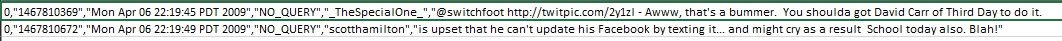

In [9]:
# Creacion de columnas plantillas segun formato del archivo
cols = ["sentiment", "id", "date", "query", "user", "text"]
train_data = pd.read_csv( "/content/gdrive/MyDrive/proyectos/data/train.csv",
                            # archivo no posee nombre de columnas
                            header=None,
                            # asignacion de las columnas
                            names=cols,
                            # uso del motos python para leer correctamente los datos
                            engine="python",

                            encoding="latin1" )
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
test_data = pd.read_csv(
    "/content/gdrive/MyDrive/proyectos/data/test.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [5]:
# visualizacion del texto data de entrenamiento
train_data.iloc[799_995:800_010]

,sentiment,id,date,query,user,text
799995,0,2329205009,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,dandykim,Sick Spending my day laying in bed listening ...
799996,0,2329205038,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,bigenya,Gmail is down?
799997,0,2329205473,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,LeeLHoke,rest in peace Farrah! So sad
799998,0,2329205574,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,davidlmulder,@Eric_Urbane Sounds like a rival is flagging y...
799999,0,2329205794,Thu Jun 25 10:28:31 PDT 2009,NO_QUERY,tpchandler,has to resit exams over summer... wishes he w...
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [6]:
# balance de la data e entranemiento vs data de test
print("Data de entrenamiento:",train_data.shape[0] , "\n\nData de test:", test_data.shape[0])

Data de entrenamiento: 1600000 

Data de test: 498


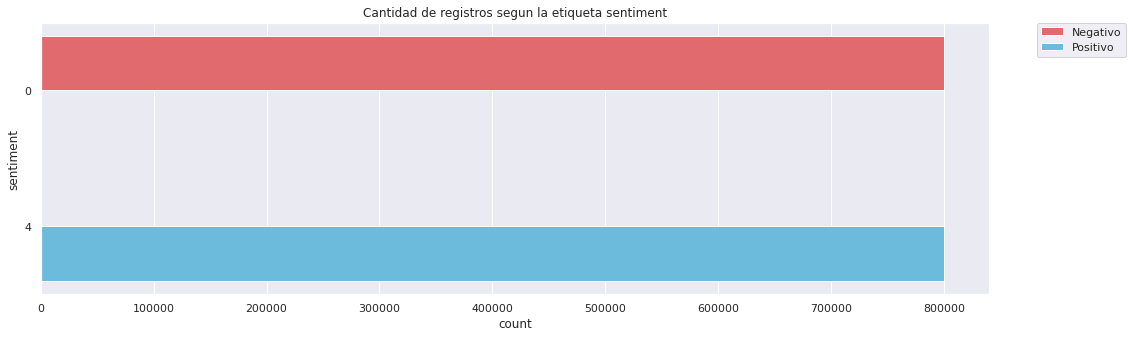

In [7]:
# Visualizacion del balance entre clases en el dataframe de entrenamiento
plt.figure(figsize=(17,5))
sns.set_theme(style="darkgrid")

ax = sns.countplot(y="sentiment", hue='sentiment', data=train_data,  palette=['#f5565b','#59c2f0'])
plt.title("Cantidad de registros segun la etiqueta sentiment")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=['Negativo', 'Positivo']);

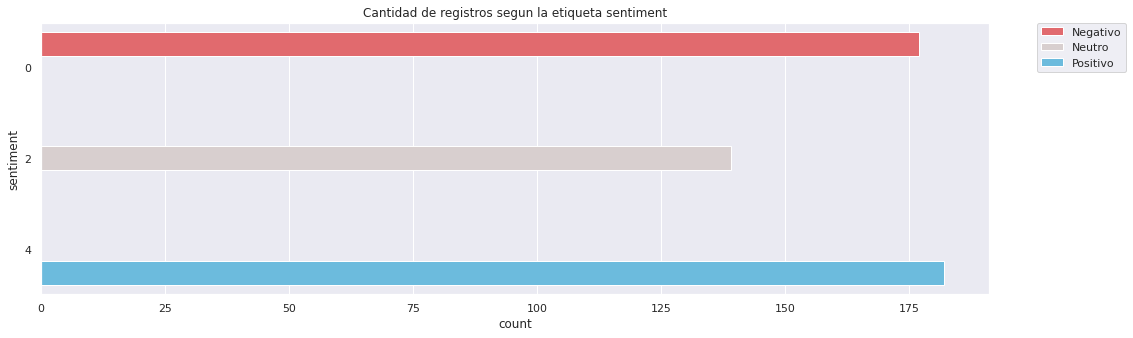

In [8]:
# Visualizacion del balance entre clases en el dataframe de test
plt.figure(figsize=(17,5))
sns.set_theme(style="darkgrid")

ax = sns.countplot(y="sentiment", hue='sentiment', data=test_data,  palette=['#f5565b','#d9cece', '#59c2f0'])
plt.title("Cantidad de registros segun la etiqueta sentiment")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=['Negativo', 'Neutro','Positivo']);

El conjunto de datos de testing tiene 3 etiquetas diferentes (una negativa, una positiva y una neutra), mientras que el conjunto de datos de entrenamiento tiene solo dos, por lo que no se usará el archivo de testing y se dividirá el archivo de entrenamiento.
El conjunto de entrenamiento posee dos tipos de valores (0 y 4), donde posee el mismo significado del conjunto de test, 0 significa negativo y 4 positivo.

## Pre Procesado

### Limpieza

In [11]:
# id    -> no es util
# date  -> no es util
# query -> no es util
# user  -> no es util
# text  -> contenido a analizar
# sentiment -> etiqueta

# Seleccion de las columnas necesarias

data =   train_data.drop(["id", "date", "query", "user"],  axis=1)
data.sample(50)

,sentiment,text
1386436,4,@Khaldonm just wait i am coming to finish th...
173726,0,does not want to go to sixth period.
612087,0,"Shit, FFE doesn't work again"
235526,0,@shanknits isnt it the coolest .... i so want ...
1253901,4,@wendyedelson ooh! don't wait-pluck it! I was ...
970965,4,with the fammm
1258509,4,@HeatherShea I'm kinda in a stunned state of d...
32062,0,Ordered the wrong edition of a cocoa programmi...
1067883,4,@MelissaAnnLong That's awesome! I love watchi...
1216042,4,@ddlovato Hope you're having agood vacation wi...


In [11]:
for tweet in data.text[:20]:
  print(tweet)

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
my whole body feels itchy and like its on fire 
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
@Kwesidei not the whole crew 
Need a hug 
@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
@Tatiana_K nope they didn't have it 
@twittera que me muera ? 
spring break in plain city... it's snowing 
I just re-pierced my ears 
@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
@octolinz16 It it counts, idk why I did either. you never talk to me anymore 
@smarrison i would've been the first, but i didn't have a gun.    not rea

In [12]:
for tweet in data.text[-25:]:
    print(tweet)

@BizCoachDeb  Hey, I'm baack! And, thanks so much for all those kind notes while I was gone. They made me smile at times when I needed it!
@mattycus Yeah, my conscience would be clear in that case. 
@MayorDorisWolfe Thats my girl - dishing out the &quot;advice&quot; 
@shebbs123 i second that 
In the garden 
@myheartandmind jo jen by nemuselo zrovna tÃ© holce ael co nic 
Another Commenting Contest! [;: Yay!!!  http://tinyurl.com/m6j2an
@thrillmesoon i figured out how to see my tweets and facebook status updates, and i was set  the groups seemed like a pain to set up...
@oxhot theri tomorrow, drinking coffee, talking about our most important and favourite issue! YOU know what I mean 
You heard it here first -- We're having a girl. Hope it has my looks and Wendy's brains. (Kidding, babe). 
if ur the lead singer in a band, beware falling prey to LSD &quot;Lead Singer Disease&quot; http://tinyurl.com/n65xjt  #music #haveyouever?
@tarayqueen too much ads on my blog. 
@La_r_a NEVEER  I think 

In [12]:
# Funcion para limpieza de las frases 

def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet, 'html.parser').get_text()
    # Eliminamos la @ y su mención con hasttags
    tweet = re.sub(r"@[A-Za-z0-9_]+", ' ', tweet)
    tweet = re.sub(r"#[A-Za-z0-9_]+", ' ', tweet)
    # Eliminamos los links de las URLs
    tweet = re.sub(r"(www|http:|https:)+[^\s]+[\w]", ' ', tweet)
    # Nos quedamos solamente con los caracteres y en minusculas
    tweet = re.sub(r"[^a-zA-Z?'\s]", ' ', tweet).lower()
    tweet = re.sub(r" \bu\b ", ' you ', tweet)
    tweet = re.sub(r" \br\b ", ' are ', tweet)
    # Convertir contracciones
    tweet = re.sub(r"'s ", ' is ', tweet) 
    tweet = re.sub(r"\bim\b|i'm\b", ' i am ', tweet) 
    tweet = re.sub(r"'ve ", ' have ', tweet) 
    tweet = re.sub(r"(can't)", 'can not ', tweet)
    tweet = re.sub(r"(won't)", ' will not ', tweet)
    tweet = re.sub(r"n't ", ' not ', tweet)
    tweet = re.sub(r"'ll", ' will ', tweet)
    tweet = re.sub(r"'re", ' are ', tweet)
    tweet = re.sub(r"'d", ' would ', tweet)
    # Eliminamos espacios en blanco adicionales
    tweet = re.sub(r"\s+", ' ', tweet).strip()
    return tweet

data_clean = [clean_tweet(tweet) for tweet in data.text]



In [15]:
# Almacenar la lista procesada/cargar lista procesada
import pickle
list_clean_path = "/content/gdrive/MyDrive/proyectos/data_cleaned/data_clean.pkl"

# with open(list_clean_path , "wb") as list_file:
#   pickle.dump(data_clean, list_file)

with open(list_clean_path , "rb") as list_file:
  data_clean = pickle.load(list_file)


print(len(data_clean))

1600000


In [19]:
# Comparación data origina vs data procesada

start = 799_990
end = 800_100

print("Data original vs. Data procesada")
for etiqueta,z in zip(data.iloc[start:end,[0,-1]].values, data_clean[start:end]):
    i = copy.copy(start)
    print("index #", i )    
    print("etiqueta ", etiqueta[0])
    print(etiqueta[1])
    print(z)
    print('\n' * 2)
    start += 1
    
    
    

Data original vs. Data procesada
index # 799990
etiqueta  0
and I think it has a mind of its own,like it always ring when I'm taking a leak..jeez that makes whole thing embarrassingly musical 
and i think it has a mind of its own like it always ring when i am taking a leak jeez that makes whole thing embarrassingly musical



index # 799991
etiqueta  0
@iaintnohomo  Banana will be playing later. BUT. Shell be playing with Caro.
banana will be playing later but shell be playing with caro



index # 799992
etiqueta  0
@koolgirl37 read my tweet below 
read my tweet below



index # 799993
etiqueta  0
My life  http://mattf.ca/2009/06/24/yay-me/
my life



index # 799994
etiqueta  0
Tried to get the mutant Fawkes to follow me but he wouldn't  it's so lonely without followers I have never had one :$
tried to get the mutant fawkes to follow me but he would not it is so lonely without followers i have never had one



index # 799995
etiqueta  0
Sick  Spending my day laying in bed listening to 

In [20]:
# Se obtienen las etiquetas finales cambiando 4 por 0

data_labels = data['sentiment'].values
# data_labels= [0 y 4]
data_labels[data_labels == 4] = 1
# data_labels= [0 y 1]
data_labels

array([0, 0, 0, ..., 1, 1, 1])

### Tokenización

In [21]:
# Se crea el tokenizer  base al corpus (lista procesada de tweets)
# Tokenizador acepta una lista como primer argumento 
# target_vocab_size la cantidad de palabras mas frecuentes (2**16 = 65536)
# De acuerdo a la version usar: tfds.features.text.SubwordTextEncoder.build_from_corpus()

tokenizer_path = '/content/gdrive/MyDrive/proyectos/tokenizer/tokenizer-encoder'

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(# Recibe la lista con frases
                                                                      data_clean,
                                                                      # indicar el limite/tamaño de palabras para analizar
                                                                      target_vocab_size=2**15)
tokenizer.save_to_file(tokenizer_path)


In [2]:
# Habilitar esta celda si el book es usado en Google Colab
from google.colab import drive
drive.mount("/content/gdrive")
# Cargar tokenizer en caso de existir
tokenizer_path = '/content/gdrive/MyDrive/proyectos/tokenizer/tokenizer-encoder'
tokenizer = tfds.deprecated.text.SubwordTextEncoder.load_from_file(tokenizer_path)

Mounted at /content/gdrive


In [3]:
# Funcion decode del tokenizer permite conocer los valores del ID de las palabras codificadas
# print(tokenizer.decode([1,2,3,4,5,6,7,8,9,10]))
# output: i to the is a my and not you it 

# Tamaño del vocabulario
tokenizer.vocab_size

# Conocer las palabras codificadas
# print(tokenizer.subwords)

33000

In [4]:
# Cada elemento (palabra) dentro la frase se codifica (conversion palabras a numeros)
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

NameError: ignored

In [27]:
print(type(data_inputs))
data_inputs[0:3]

<class 'numpy.ndarray'>


array([[  488,    17,     4,     5,  1867,     6,  4145,    46,   909,
        17070,    14,  2176,    40,     2,    25,    10, 32844,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    4,   918,    17,    75,    29,     9,   620,   171,   635,
          109,  2429,    10,     8,   273,   750,    71,     5,  3086,
          155,    54,   264,  3271,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
     

### Padding

In [26]:
# MAX_LEN obtenemos el longitud máxima de la lista 
# padding="post" y value=0 indicamos  que los elementos con longitud menores al MAX_LEN se llenaran con ceros al final
# Ya que la red neuronal requiere que los elementos ingresen con una misma longitud, sin embargo, internamente los ceros seran 
# ignorados y solo analizará los valores
# donde todas las frases seran del mismo tamaño


MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

In [28]:
data_labels

array([0, 0, 0, ..., 1, 1, 1])

### Dividimos en los conjuntos de entrenamiento y de testing


In [29]:
# En revision de la data, los primeros 800000 registros son de caategoria 0
# y los 800000 restantes son positivos
# [1,4,6,8] + 8 = [8,12,14,16]
# se generan index aleatorios para el set de test

test_idx = np.random.randint(0,  high=800000, size=8000)
test_idx = np.concatenate((test_idx, test_idx+800000))

In [30]:
# Se toman los valores segun index pre fabricados para el set de test como ambas etiquetas
test_inputs = data_inputs[test_idx]
test_labels = data_labels[test_idx]

train_inputs = np.delete(data_inputs, test_idx, axis=0)
train_labels = np.delete(data_labels, test_idx)

# Fase 3: Construción del modelo

Definiendo la Arquitectura

In [43]:
# Crear clase que herede de keras Modelo

class DCNN(tf.keras.Model):
    
    def __init__(self,
                 # palabras a manejar segun el tokenizer
                 # El tokenizer ofrece esta informacion tokenizer.vocab_size
                 vocab_size,
                 #palabra reducida a espacio vectorial de tamaño 128
                 emb_dim=128,
                 # cantidad por fitros a utilizar 2,4,5,6,
                 nb_filters=50,
                 # Numero de neuronas capa oculta
                 FFN_units=1024,
                 # Cantidad de clases 0 o 1
                 nb_classes=2,
                 # Porcentaje de desactivacion de neuronas
                 dropout_rate=0.2,
                 # False para hacer predicciones True para entrenar                 
                 training=False,
                 # Nombre de la red
                 name="dcnn"):
        
        # Llamar a la funcion con la clase padre
        super(DCNN, self).__init__(name=name)
        # embedding es la primera capa oculta de una RN
        # Requiere 3 argumentos
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        # FAMILIA DE FILTROS
        # filters numero de filtros
        # kernel_size: cantidad de palabras grupos
        # padding valid completar con ceros si sobran palabras de kernel_size
        # activation funcion 
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        # Obtener los elementos con mayor aporte 
        self.pool = layers.GlobalMaxPool1D() # No tenemos variable de entrenamiento
                                             # así que podemos usar la misma capa 
                                             # para cada paso de pooling
        # Capa Densa y oculta         
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    # input bloque de frases a predecir
    # trainin Bool 
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [44]:
# Crear clase que herede de keras Modelo
# La clase DCNN corresponde al algoritmo de red neuronal convolusional para NLP (Natural Language Processing)

class DCNN(tf.keras.Model):
    
    def __init__(self,
                 # palabras a manejar segun el tokenizer
                 # El tokenizer ofrece esta informacion tokenizer.vocab_size
                 vocab_size,
                 #palabra reducida a espacio vectorial de tamaño 128
                 emb_dim=128,
                 # cantidad por fitros a utilizar 2,4,5,6,
                 nb_filters=50,
                 # Numero de neuronas capa oculta
                 FFN_units=1024,
                 # Cantidad de clases 0 o 1
                 nb_classes=2,
                 # Porcentaje de desactivacion de neuronas
                 dropout_rate=0.20,
                 # False para hacer predicciones True para entrenar                 
                 training=False,
                 # Nombre de la red
                 name="dcnn"):
        
        # Llamar a la funcion con la clase padre
        super(DCNN, self).__init__(name=name)
        # embedding es la primera capa oculta de una RN
        # Por lo general requiere 3 argumentos
        
        # input_dim : tamaño del vocabulario. Los datos deben estar codificados en números enteros 
        # output_dim : este es el tamaño del espacio vectorial en el que se incrustarán las palabras. Define el tamaño de los vectores de salida de esta capa para cada palabra. Por ejemplo, podría ser 32 o 100 o incluso más. Pruebe diferentes valores para su problema.
        # input_length : esta es la longitud de las secuencias de entrada, como definiría para cualquier capa de entrada de un modelo de Keras. Por ejemplo, si todos sus documentos de entrada se componen de 1000 palabras, esto sería 1000.



        self.embedding = layers.Embedding(vocab_size, emb_dim )
        
        # FAMILIA DE FILTROS
        # filters numero de filtros
        # kernel_size: cantidad de palabras grupos
        # padding valid completar con ceros si sobran palabras de kernel_size
        # activation funcion 
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        # Obtener los elementos con mayor aporte 
        self.pool = layers.GlobalMaxPool1D() # No tenemos variable de entrenamiento
                                             # así que podemos usar la misma capa 
                                             # para cada paso de pooling
        # Capa Densa y oculta         
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    # input bloque de frases a predecir
    # trainin Bool 
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# Paso 4: Aplicación

## Configuración

In [45]:
VOCAB_SIZE = tokenizer.vocab_size 

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 # o len(set(train_labels))

DROPOUT_RATE = 0.2

BATCH_SIZE = 32
NB_EPOCHS = 5

## Entrenamiento

In [46]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [47]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [ ]:
# Arquitectura 1

# checkpoint_path = "/content/gdrive/MyDrive/proyectos/chpk"

# ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print("Último checkpoint restaurado!!")

In [48]:
# Arquitectura 2

checkpoint_path = "/content/gdrive/MyDrive/proyectos/chpk2"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Último checkpoint restaurado!!")

In [49]:
Dcnn.fit(train_inputs,
         train_labels,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)
ckpt_manager.save()

Epoch 1/5
49503/49503 [==============================] - 764s 15ms/step - loss: 0.4073 - accuracy: 0.8151
Epoch 2/5
49503/49503 [==============================] - 754s 15ms/step - loss: 0.3573 - accuracy: 0.8437
Epoch 3/5
49503/49503 [==============================] - 747s 15ms/step - loss: 0.3204 - accuracy: 0.8631
Epoch 4/5
49503/49503 [==============================] - 749s 15ms/step - loss: 0.2814 - accuracy: 0.8824
Epoch 5/5
49503/49503 [==============================] - 740s 15ms/step - loss: 0.2426 - accuracy: 0.9005


'/content/gdrive/MyDrive/proyectos/chpk2/ckpt-1'

## Evaluación

In [50]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(results)

500/500 [==============================] - 3s 5ms/step - loss: 0.4612 - accuracy: 0.8206
[0.46124643087387085, 0.8206250071525574]


In [51]:
tokenizer.encode( clean_tweet("i am going to a funeral because my enemy dies ")  )

[1, 11, 44, 2, 5, 3727, 196, 7, 11134, 8018]

## Pruebas

In [67]:
from logging import exception
# Defino una funcion para obtener el resultado del modelo

def predictor_sentimiento(modelo, texto="", stat = False):
  
  if len(texto.split()) < 2:
    print("Por favor introduzca una frase con 3 o mas palabras")
  else:
    
    try:
      resultado = modelo(np.array([tokenizer.encode(  clean_tweet(texto) )]), training=False).numpy()
      if resultado[0] < 0.4:
        print("esta frase esta clasificada como NEGATIVA", f"Con {resultado[0][0] * 100:.2f}% nivel de positividad." if stat else '') 
        
      else:
        print("esta frase esta clasificada como POSITIVA", f"Con {resultado[0][0] * 100:.2f}% nivel de positividad." if stat else '')
        
    except :
      print("Ocurrió un error al calcular el sentimiento de la frase. \n intente reformular la frase o agregue mas palabras")

In [59]:
predictor_sentimiento(Dcnn, texto = " i am happy because i'm going to a funeral  because my enemy died ")

esta frase esta clasificada como NEGATIVA 


In [60]:
predictor_sentimiento(Dcnn, texto = "i'm going to a funeral  because my enemy died ")

esta frase esta clasificada como NEGATIVA 


In [66]:
predictor_sentimiento(Dcnn, texto = " It’s never too late to fail.", stat = True)

esta frase esta clasificada como NEGATIVA Con 39.61% de probabilidad de ser positivo.
